In [1]:
import json
import os
import ast
import csv
import io
from io import StringIO, BytesIO, TextIOWrapper
import gzip
from datetime import datetime, date
from s3_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ast
from datetime import timedelta
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import warnings
import sys
import time
warnings.filterwarnings("ignore")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-aaxf1e_0 because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Define s3 bucket
bucket = 'fouryouandme-study-data'

#List s3 keys
# get_matching_s3_keys(bucket, prefix='bump/') #Remove prefix to view non-BUMP data
bucket = '4youandme-study-data' # for SinC project
bucket = 'fouryouandme-study-data' # for 4YouandMe, Bump, CamCog or Bodyport project

# prefix = {study_name} or {study_name}/{source}
# sources: app_activities, bodyport, camcog, garmin, oura, redcap, rescuetime
# note camcog not accessible to bodyport (and vice a versa)
get_matching_s3_keys(bucket, prefix='bump/oura')
key = 'bump/redcap/wave_4/study_ids.csv.gz'
df_studyID = pandas_from_csv_s3(bucket, key=key, compression='gzip')

# Some dataframes use 'record_id' instead of 'user_id'. 
# You'll need to match it up with df_studyID where'evidation_id' is 'user_id'
# NOTE: Very few examples of this. Birthing data is the important one

# Birthing Data
key = 'bump/redcap/wave_4/birthing_data_cohort_2_only.csv.gz'
df_birth = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date


df_birth = pd.merge(df_birth, df_studyID, on='record_id')
df_birth['user_id'] = df_birth.evidation_id

# There is a missing value in the birthing data. I'm removing it here
df_birth = df_birth.drop(index=50)

# Bodyport Wave 4
key = 'bump/bodyport/wave_4/bodyport.csv.gz'
df_bodyport = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# OPTIONAL: Convert date format
df_bodyport['date'] = pd.to_datetime(df_bodyport.event_date).dt.date 

# Oura Wave 4
key = 'bump/oura/wave_4/oura_sleep.csv.gz'
df_sleep = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sleep['date'] = pd.to_datetime(df_sleep.event_date).dt.date

key = 'bump/oura/wave_4/oura_activity.csv.gz'
df_activity = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_activity['date'] = pd.to_datetime(df_activity.event_date).dt.date

key = 'bump/oura/wave_4/oura_readiness.csv.gz'
df_readiness = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_readiness['date'] = pd.to_datetime(df_readiness.event_date).dt.date

# Surveys Wave 4
key = 'bump/app_activities/wave_4/surveys.csv.gz'
df_survey = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_survey['date'] = pd.to_datetime(df_survey.updated_at).dt.date

key = 'bump/app_activities/wave_4/quick_activities.csv.gz'
df_sam = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sam['date'] = pd.to_datetime(df_sam.event_date).dt.date

dfs = [df_sleep, df_bodyport, df_birth, df_activity, df_readiness, df_survey, df_sam]

In [3]:
# get all column names in merged dfs
names = []
for df in dfs:
    [names.append(i) for i in df.columns.to_list()]

In [4]:
bodyport_features = [
    # 'heart_rate',
    # 'breath_average',
    # 'peripheral_fluid',
    # 'total_body_water_percent',
    # 'weight_kg'
]
oura_features = [
    # 'hr_lowest',
    'hr_average',
    'rmssd',
    # 'score_deep',
    # 'temperature_deviation',
    # 'temperature_trend_deviation',
    # 'temperature_delta',
    # 'duration',
    # 'rem',
    # 'efficiency',
    # 'score_alignment',
    # 'score_rem',
    # 'light',
    # 'onset_latency',
    # 'restless',
    'breath_average',
    # 'score_disturbances',
    'score',
    # 'score_efficiency',
    # 'score_latency',
    # 'score_total'
]
feature_names = bodyport_features + oura_features
date_list = [
    "d", "id_x", 
    "user_id_x", 
    "identity_id_x", 
    "created_at_x", 
    "updated_at_x", 
    "retrieved_at_x", 
    "subsource_x", 
    "event_date_x",
    "date", "id_y", 
    "user_id_y", 
    "identity_id_y", 
    "created_at_y", 
    "updated_at_y", 
    "retrieved_at_y", 
    "subsource_y", 
    "creation_date", 
    "event_date_y"
]

In [5]:
def get_user(user_id, start=None, end=None):
    user_sleep = df_sleep[df_sleep.user_id == user_id]#.dropna()
    user_bp = df_bodyport[df_bodyport.user_id == user_id]#.dropna()
    
    df2 = pd.merge(user_sleep, user_bp, on="date")

    if "creation_date" in df2.columns:
        for i in range(len(df2)):
            df2["creation_date"][i] = dt.datetime.strptime(df2["creation_date"][i], '%Y-%m-%d %H:%M:%S')
    df2.set_index(df2["date"], inplace=True)
    df2.sort_index(inplace=True)
    
    if start and end:
        mask = (df2['date'] > np.datetime64(start)) & (df2['date'] <= np.datetime64(end))
        # mask = pd.to_datetime(df2["date"]).between(start.astype(str)[0], end.astype(str)[0], inclusive=True)
        df2 = df2[mask]
    return df2

In [6]:
#merge all data features
close_users = []
close_users_id = []
start_close_days = 90
for user_id in tqdm(df_birth[['birth_scheduled', 'birth_date', 'user_id']].dropna().user_id.unique()):
    birth = df_birth.loc[df_birth.user_id == user_id]
    birthdate = birth.reset_index()['date'][0]
    schedule_birth = birth['birth_scheduled'].to_list()[0] #schedule_birth == 1: induced deliveries; schedule_birth == 2: non induced
    if len(birth) > 0 and pd.isnull(birthdate) == False and schedule_birth == 2:
        start = birthdate - pd.to_timedelta(start_close_days, unit='d') # pd.to_timedelta(100, unit='d')
        end = birthdate + pd.to_timedelta(5, unit='d')
        date_range = pd.date_range(start, end, freq='d')
        df = get_user(user_id, start, birthdate)
        dr = pd.DataFrame()
        dr["d"] = date_range.date
        dr.set_index(dr.d, inplace=True)
        df = dr.join(df)
        df = df[feature_names + date_list]
        if df.isna().sum().max() < round(start_close_days) / 2: # max null counts in each col is less than 5
            df.set_index(df.d - df.d.min(), inplace=True)
            df = df.resample("D").mean()
            df.set_index(df.index.days, inplace=True)
            # df = df.interpolate("linear", 0) #linear interpolation on data
            df = df.fillna(method='ffill')
            df = df.fillna(df.mean(0))
            close_users.append(df)
            close_users_id.append(user_id)
            

100%|██████████| 138/138 [00:02<00:00, 49.22it/s]


In [7]:
len(close_users_id)

27

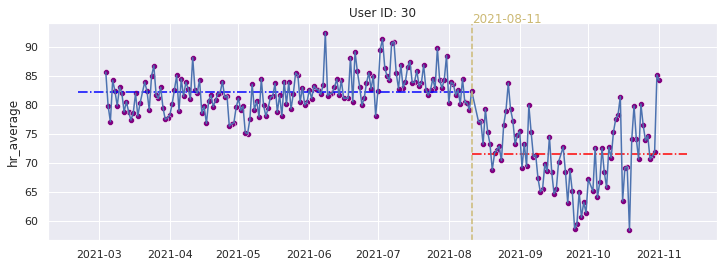

In [8]:
def exploreDataBirthBA(df, col, user_id):
    plt.rcParams.update({'figure.max_open_warning': 0})
    sns.set_theme(style='darkgrid')
    pdf = df.loc[df.user_id == user_id]    
    plt.figure(figsize=(12,4))
    sns.scatterplot(data=pdf, x='date', y=col, ci=None, color='purple')
    sns.lineplot(data=pdf, x='date', y=col, ci=None)

    # Plot birthing data if it exists for that user
    if (len(df_birth.loc[df_birth.user_id == user_id]) != 0):
        birth = df_birth.loc[df_birth.user_id == user_id].reset_index()
        plt.axvline(x=birth.date, color = 'y', ls='--')
        ymin, ymax = plt.gca().get_ylim()
        xmin, xmax = plt.gca().get_xlim()
        plt.text(birth.date, ymax, birth['date'][0], fontsize=12, color='y')
        
        # Dataframe of data before birth
        after = pdf[~(pdf['date'] < birth.date[0])]
        before = pdf[~(pdf['date'] > birth.date[0])]
        before_avg = before[col].mean()
        after_avg = after[col].mean()
#         print('Pre-birth Average: ', before_avg)
#         print('Post-birth Average: ', after_avg)
        plt.hlines(y=before_avg, xmin=xmin, xmax=birth.date, color='blue', linestyles='dashdot')
        plt.hlines(y=after_avg, xmin=birth.date, xmax=xmax, color='red', linestyles='dashdot')
#         sns.lineplot(data=before, x='date', y=col, ci=None, color='r')
#         sns.lineplot(data=after, x='date', y=col, ci=None, color='r')

    plt.xlabel(''); plt.ylabel(col)
    plt.title('User ID: ' + str(user_id))
    plt.show()
exploreDataBirthBA(df_sleep, 'hr_average', 30)